# 0. Hyperparameters
and imports

In [1]:
from evaluate_yolo_tracker import evaluate_sequence, VAL_SEQUENCES
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pandas as pd
import numpy as np
import cv2
import os

Error importing BURST due to missing underlying dependency: No module named 'pycocotools'


In [2]:
IOU_ASSOCIATION_TRESHOLD = 0.5
CONF_TRESHOLD = 0.2
project = '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/SharkTrack-Dev/models/p2v4_new_1000e_no_patience/'
custom_botsort_path = '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/SharkTrack-Dev/trackers/custom_botsort.yaml'

# 1. Run Tracking

In [3]:
model_path = os.path.join(project, 'weights/best.pt')

custom = True
tracker = custom_botsort_path if custom else 'botsort'


print(tracker)
motas, motps, idf1s, hotas, track_time, _, aligned_annotations_list = evaluate_sequence(model_path, CONF_TRESHOLD, IOU_ASSOCIATION_TRESHOLD, imgsz=640, tracker_type=tracker)
print(f'MOTA: {motas}, MOTP: {motps}, IDF1: {idf1s}, HOTA: {hotas}, {track_time=}s')

/vol/biomedic3/bglocker/ugproj2324/fv220/dev/SharkTrack-Dev/trackers/custom_botsort.yaml
Evaluating val1_difficult1
Running track mode...


Processing frame 100

Processed 100 frames in track mode.
Sequence processing time: 8.47s
Evaluating val1_difficult2
Running track mode...
Processing frame 100

Processed 100 frames in track mode.
Sequence processing time: 6.58s
Evaluating val1_easy1
Running track mode...
Processing frame 100

Processed 100 frames in track mode.
Sequence processing time: 6.02s
Evaluating val1_easy2
Running track mode...
Processing frame 100

Processed 100 frames in track mode.
Sequence processing time: 8.30s
Evaluating val1_medium1
Running track mode...
Processing frame 100

Processed 100 frames in track mode.
Sequence processing time: 10.45s
Evaluating val1_medium2
Running track mode...
Processing frame 100

Processed 100 frames in track mode.
Sequence processing time: 6.98s

Eval Config:
USE_PARALLEL         : False                         
NUM_PARALLEL_CORES   : 8                             
BREAK_ON_ERROR       : True                          
RETURN_ON_ERROR      : False                         


<Figure size 640x480 with 0 Axes>

# Investigate with GT
For frames with poor graph performance, show the GT and PRED bounding boxes

In [2]:
def draw_bbox(img, gt_bbox, pred_bbox, pred_conf, track_ids, im=None):
  color1 = (0, 255, 0)
  color2 = (0, 0, 255)

  for bbox in gt_bbox:
    bbox = np.array(bbox).astype(int)
    pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
    img = cv2.rectangle(img, pt1, pt2, color1, int(max(img.shape[:2]) / 200))

  for i, pair in enumerate(zip(pred_bbox, pred_conf)):
    bbox, conf = pair
    bbox = np.array(bbox).astype(int)
    pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
    img = cv2.rectangle(img, pt1, pt2, color2, int(max(img.shape[:2]) / 200))
    text = f'Pred: {conf:.2f}'
    if len(track_ids) > 0:
      text += f' (ID: {track_ids[i]})'
    img = cv2.putText(img, text, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color2, 1, cv2.LINE_AA)

  # Add legend for color
  img = cv2.putText(img, 'Ground Truth', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color1, 2, cv2.LINE_AA)
  img = cv2.putText(img, 'Predictions', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, color2, 2, cv2.LINE_AA)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  if im:
    im.set_data(img_rgb)
  else:
    plt.imshow(img_rgb)


def plot_frame(frame_path, frame_num, aligned_annotations):
  """
  Plots the ground truth and predicted bounding boxes of a given frame.
  """
  gt_bbox = aligned_annotations['gt_bbox_xyxys'][frame_num]
  pred_bbox = aligned_annotations['pred_bbox_xyxys'][frame_num]
  pred_conf = aligned_annotations['pred_confidences'][frame_num]
  track_ids = aligned_annotations['pred_track_ids']
  if len(track_ids) > 0:
    track_ids = track_ids[frame_num]

  # Convert frame number to timestamp (in milliseconds)
  timestamp = (frame_num / 10) * 1000  # frame_num / fps * 1000

  # Read the frame
  frame = cv2.imread(frame_path)

  # Plot the ground truth and predicted bounding boxes
  draw_bbox(frame, gt_bbox, pred_bbox, pred_conf, track_ids)

In [27]:
dataset = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/frame_extraction_raw/val1/frames_5fps'

In [ ]:
# Bulk It
sequence = 'val1_medium2'
print(f'Inspecting sequence {sequence}')
seq_annotations = aligned_annotations_list[sequence]
for frame_to_inspect in range(len(seq_annotations['gt_bbox_xyxys'])):
  conf = seq_annotations['pred_confidences'][frame_to_inspect]
  track_id = seq_annotations['pred_track_ids'][frame_to_inspect]
  print(f'Frame {frame_to_inspect}, conf: {conf}, track_id: {track_id}')
  frame_name = f'{sequence}_frame{frame_to_inspect*2}.jpg'
  frame_path = os.path.join(dataset, sequence, frame_name)
  plot_frame(frame_path, frame_to_inspect, seq_annotations)
  plt.show()
  plt.pause(1)

# Investigate Inference

In [14]:
def get_annotations(df, frame_num):
  """
  Given dataframe with following columns:
  row['4-7: Img-bbox(TL_x']
  row['TL_y']
  row['BR_x']
  row['BR_y)']

  extract list of bounding boxes for col '3: Unique Frame Identifier' = frame_num
  """
  bboxes = df[df['3: Unique Frame Identifier'] == frame_num][['4-7: Img-bbox(TL_x', 'TL_y', 'BR_x', 'BR_y)']].values.tolist()
  confs = df[df['3: Unique Frame Identifier'] == frame_num]['8: Detection or Length Confidence'].values.tolist()
  pred_track_ids = df[df['3: Unique Frame Identifier'] == frame_num]['# 1: Detection or Track-id'].values.tolist()
  return bboxes, confs, pred_track_ids

def plot_from_video(video, frame_num, fps, annotations, im=None):
  """
  Plots the ground truth and predicted bounding boxes of a given frame.
  """
  pred_bboxes, pred_confs, pred_track_ids = get_annotations(annotations, frame_num)

  # Convert frame number to timestamp (in milliseconds)
  print(frame_num)
  timestamp = ((frame_num) / fps) * 1000  # frame_num / fps * 1000

  # Extract the frame from the video at the specific timestamp
  cap = cv2.VideoCapture(video)
  cap.set(cv2.CAP_PROP_POS_MSEC, timestamp)
  ret, frame = cap.read()
  cap.release()


  # Plot the ground truth and predicted bounding boxes
  draw_bbox(frame, [], pred_bboxes, pred_confs, pred_track_ids, im)


In [ ]:
annotations = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/annotations/mwitt/AXA_NOV23_v3_non_empty_2'

for bruv in os.listdir(annotations):
  if not bruv == 'AXA_2023-2091011':
    continue
  for annotation in os.listdir(os.path.join(annotations, bruv))[::-1]:
    if annotation != 'LGX080026_tracks_5fps.csv':
      continue
    assert annotation.endswith('.csv')
    video_path = os.path.join('/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/videos_raw/mwitt/AXA_NOV23_no_streams', bruv, annotation.replace('_tracks_5fps.csv', '.mp4'))
    predictions = os.path.join(annotations, bruv, annotation)
    predictions_df = pd.read_csv(predictions, skiprows=lambda x: x in [1])

    print(f'processing {predictions}...')

    fps = 5
    track_ids = set()
    frames = set()
    for index, row in predictions_df.iterrows():
      frame_to_inspect = row['3: Unique Frame Identifier']
      conf = row['8: Detection or Length Confidence']
      track_id = row['# 1: Detection or Track-id']
      # skip every 10 frames
      if any([frame_to_inspect + n in frames for n in range(-5, 5)]): 
        continue
      frames.add(frame_to_inspect)
      # if track_id in track_ids:
        # continue
      track_ids.add(track_id)
      print(f'{frame_to_inspect=}, {conf=}, time: {frame_to_inspect/fps}, {track_id=} {predictions.replace("/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/annotations/mwitt/AXA_NOV23_v3_non_empty_2/", "")}')
      plot_from_video(video_path, frame_to_inspect, fps, predictions_df)
      plt.pause(1)


# 7. Bulk-Test all videos

In [ ]:
video_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/grayscale_videos/'
annotations_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/annotations/'
model_path = '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/shark_locator_tests/runs/detect/train3/weights/best.pt'

In [ ]:
videos = os.listdir(video_folder)
print('testing model ' + model_path)
model = YOLO(model_path)

motas = []
motps = []
idf1s = []

for video in videos:
  print(f'Evaluating {video}')
  video_path = video_folder + video
  annotations_path = annotations_folder + video[:-4] + '.csv'
  annotations = pd.read_csv(annotations_path)
  results = model.track(source=video_path, persist=True, conf=CONF_TRESHOLD, verbose=False)
  extracted_pred_results = yolo_extract_tracks(results)
  aligned_annotations = align_annotations_with_predictions_dict_corrected(annotations, extracted_pred_results, VIDEO_LENGTH)
  mota, motp, idf1, frame_avg_motp = evaluate_tracking(aligned_annotations, IOU_ASSOCIATION_TRESHOLD)
  motas.append(mota)
  motps.append(motp)
  idf1s.append(idf1)
  print(f'{video} - MOTA: {round(mota, 2)}, MOTP: {round(motp, 2)}, IDF1: {round(idf1, 2)}')
  plot_performance_graph(aligned_annotations, frame_avg_motp)

print(f'Avg results: MOTA: {round(np.mean(motas), 2)}, MOTP: {round(np.mean(motps), 2)}, IDF1: {round(np.mean(idf1s), 2)}')

# Postprocessing

In [4]:
from collections import Counter

In [101]:
def bucketise_values(shark, no_shark, min_val, max_val):
    bucket_size = (max_val - min_val) / 20
    conf_no_shark_tracks_frequency = {f'{min_val + i * bucket_size:.2f}': 0 for i in range(20)}
    conf_shark_tracks_frequency = {f'{min_val + i * bucket_size:.2f}': 0 for i in range(20)}

    for k, v in no_shark.items():
        if v < min_val:
            bucket_index = 0
        elif v >= max_val:
            bucket_index = 19
        else:
            bucket_index = int((v - min_val) / bucket_size)
        bucket = min_val + bucket_index * bucket_size
        conf_no_shark_tracks_frequency[f'{bucket:.2f}'] += 1

    for k, v in shark.items():
        if v < min_val:
            bucket_index = 0
        elif v >= max_val:
            bucket_index = 19
        else:
            bucket_index = int((v - min_val) / bucket_size)
        bucket = min_val + bucket_index * bucket_size
        conf_shark_tracks_frequency[f'{bucket:.2f}'] += 1
  
    return conf_no_shark_tracks_frequency, conf_shark_tracks_frequency


def get_track_avg_bbox_size(annotation_df, track_id):
  # return 1000s pixels
  track_bboxes = annotation_df[annotation_df['# 1: Detection or Track-id'] == track_id][['4-7: Img-bbox(TL_x', 'TL_y', 'BR_x', 'BR_y)']].values
  bbox_sizes = []
  for bbox in track_bboxes:
    bbox = np.array(bbox).astype(int)
    bbox_sizes.append((bbox[2] - bbox[0]) * (bbox[3] - bbox[1]))
  return round(np.mean(bbox_sizes) / 1000, 1)

def plot_length_frequency(shark, no_shark):
  # plot both occurances on the same fig with two colors
  plt.bar(no_shark.keys(), no_shark.values(), color='b', label='No Shark', alpha=0.5)
  plt.bar(shark.keys(), shark.values(), color='r', label='Shark', alpha=0.5)

  # Set x ticks every 5
  plt.xticks(range(min(no_shark.keys())-1, max(shark.keys())+1, 10))

  plt.legend()
  plt.title('Track length frequency')
  plt.show()

def plot_max_conf_frequency(shark, no_shark):
  # make figure bigger
  plt.figure(figsize=(10, 5))

  # plot both occurances on the same fig with two colors
  plt.bar(no_shark.keys(), no_shark.values(), color='b', label='No Shark', alpha=0.5)
  plt.bar(shark.keys(), shark.values(), color='r', label='Shark', alpha=0.5)


  plt.legend()
  plt.title('Track max confidence frequency')
  plt.show()

def plot_bbox_freq(shark, no_shark):
  # make figure bigger
  plt.figure(figsize=(20, 10))

  # plot both occurances on the same fig with two colors
  plt.bar(no_shark.keys(), no_shark.values(), color='b', label='No Shark', alpha=0.5)
  plt.bar(shark.keys(), shark.values(), color='r', label='Shark', alpha=0.5)


  plt.legend()
  plt.xlabel('Bbox size (*1000s pixels)')
  plt.title('Track bbox_avg_size frequency')
  plt.show()

def get_track_info(annotation_dir, is_track_shark, filter_chapter=None, filter_video=None):
  """
  filter video: list of videos it should be
  """
  length_tracks_no_shark = {}
  length_tracks_shark = {}

  conf_tracks_no_shark = {}
  conf_tracks_shark = {}

  bbox_avg_size_tracks_no_shark = {}
  bbox_avg_size_tracks_shark = {}
  
  for folder in os.listdir(annotation_dir):
    if filter_chapter and filter_chapter not in folder:
      continue
    for annotation in os.listdir(os.path.join(annotation_dir, folder)):
      sequence_name = annotation.replace("_tracks_5fps.csv", "")
      if not annotation.endswith('.csv'):
        continue
      if filter_video and sequence_name not in filter_video:
        continue

      annotation_path = os.path.join(annotation_dir, folder, annotation)
      annotations = pd.read_csv(annotation_path, skiprows=lambda x: x in [1])
      track_ids = set(annotations['# 1: Detection or Track-id'])
      for track_id in track_ids:
        track_length = len(annotations[annotations['# 1: Detection or Track-id'] == track_id])
        track_max_conf = annotations[annotations['# 1: Detection or Track-id'] == track_id]['8: Detection or Length Confidence'].max()
        track_avg_bbox_size = get_track_avg_bbox_size(annotations, track_id)
        track_name = f"{folder}/{sequence_name}_track{track_id}"
        

        if not is_track_shark(folder, sequence_name, annotations, track_id):
          length_tracks_no_shark[track_name] = track_length
          conf_tracks_no_shark[track_name] = track_max_conf
          bbox_avg_size_tracks_no_shark[track_name] = track_avg_bbox_size
        else:
          length_tracks_shark[track_name] = track_length
          conf_tracks_shark[track_name] = track_max_conf
          bbox_avg_size_tracks_shark[track_name] = track_avg_bbox_size

  return length_tracks_no_shark, length_tracks_shark, conf_tracks_no_shark, conf_tracks_shark, bbox_avg_size_tracks_no_shark, bbox_avg_size_tracks_shark



### 1. Track length
Assumption: Alage FP have shorter tracks (appear-disappear)

### Mwitt

In [84]:
def mwitt_is_shark(source, sequence_name, annotation_df, track_id):
  right_video = '2091011' in source and 'LGX080026' in sequence_name
  right_track = track_id not in [6, 21]

  return right_track and right_video
  

In [102]:
annotation_dir = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/annotations/mwitt/AXA_NOV23_v3_non_empty_2'
length_tracks_no_shark, length_tracks_shark, conf_tracks_no_shark, conf_tracks_shark, bbox_avg_size_tracks_no_shark, bbox_avg_size_tracks_shark = get_track_info(annotation_dir, mwitt_is_shark)
print(len(length_tracks_no_shark), len(length_tracks_shark))

1572 6


In [105]:
short_tracks = [k for k, v in length_tracks_no_shark.items() if v <= 5]
short_low_conf =  [k for k, v in conf_tracks_no_shark.items() if k in short_tracks and v <= 0.85]
print(f'shorter than 1s {len(short_tracks)}, low conf {len(short_low_conf)}')

shorter than 1s 1103, low conf 685


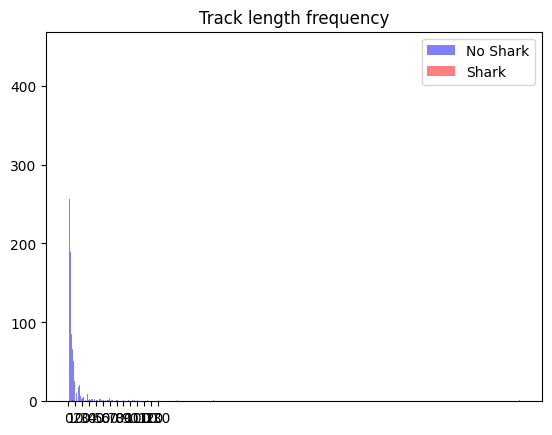

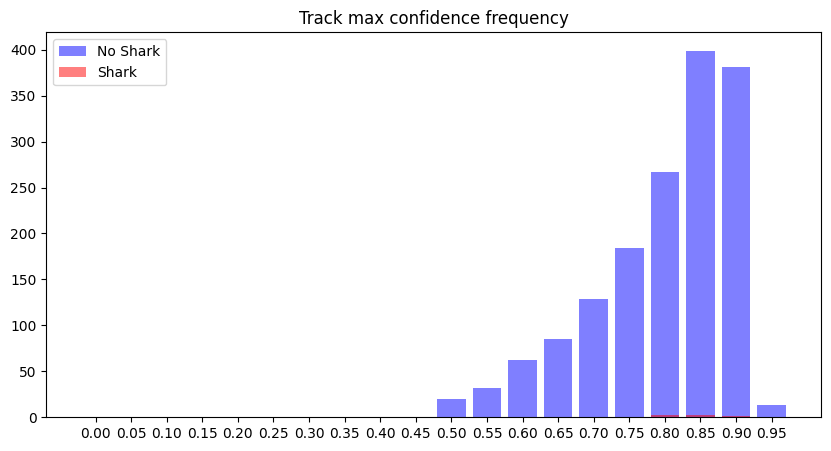

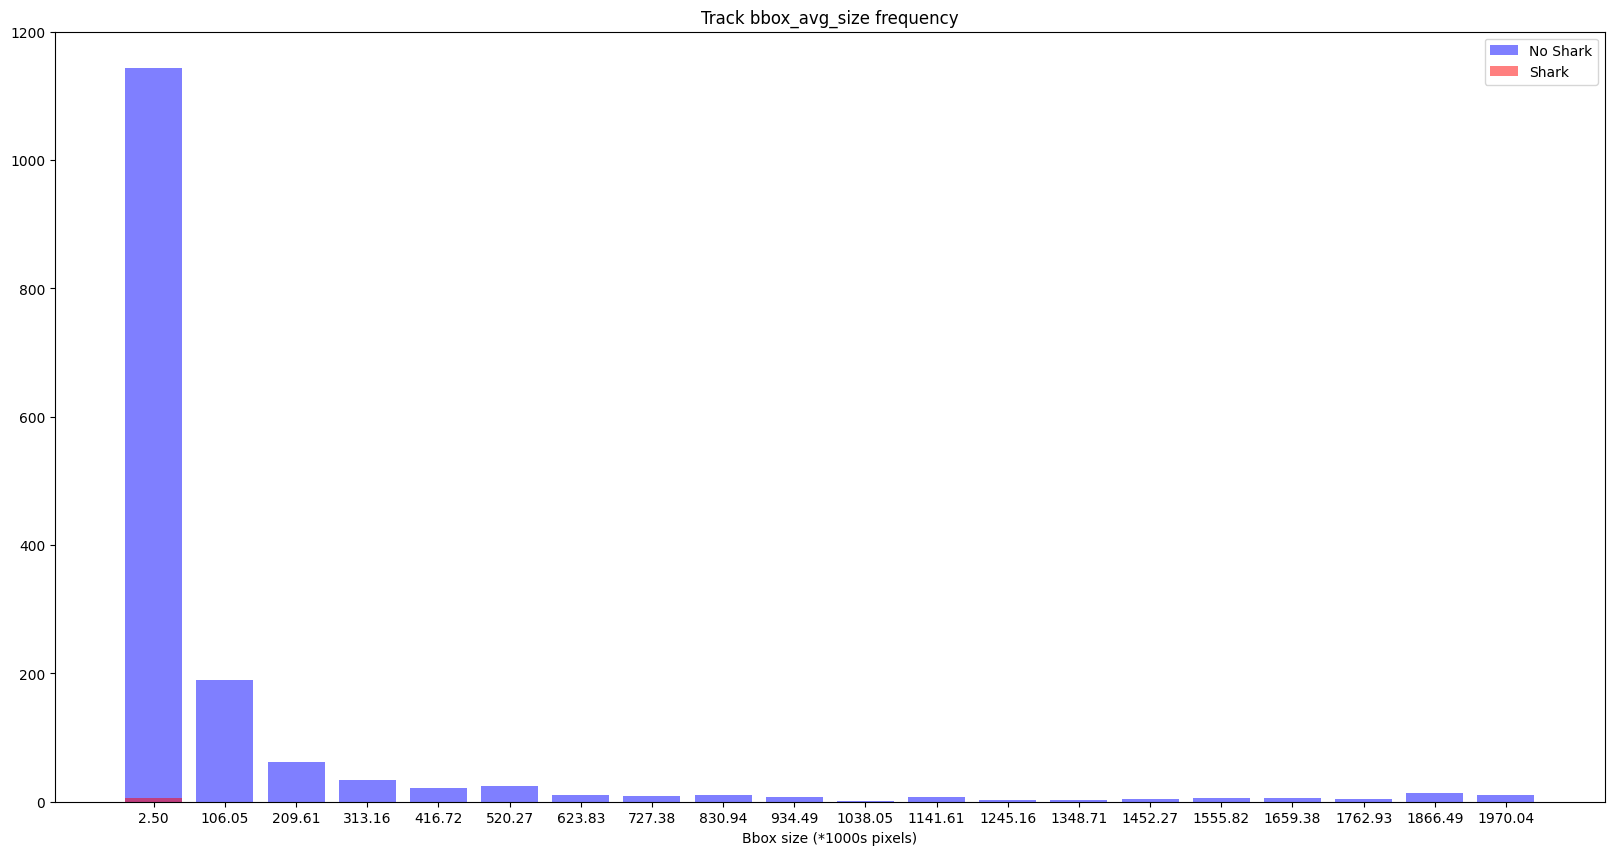

In [106]:
# length
tracks_no_shark_frequency = Counter(length_tracks_no_shark.values())
tracks_shark_frequency = Counter(length_tracks_shark.values())

plot_length_frequency(tracks_shark_frequency, tracks_no_shark_frequency)

# conf
conf_tracks_no_shark_freq, conf_tracks_shark_freq = bucketise_values(conf_tracks_shark, conf_tracks_no_shark, 0, 1)
plot_max_conf_frequency(conf_tracks_shark_freq, conf_tracks_no_shark_freq)


# size
max_bbox_size = max(max(bbox_avg_size_tracks_no_shark.values()), max(bbox_avg_size_tracks_shark.values()))
min_bbox_size = min(min(bbox_avg_size_tracks_no_shark.values()), min(bbox_avg_size_tracks_shark.values()))

bbox_avg_size_tracks_no_shark_freq, bbox_avg_size_tracks_shark_freq = bucketise_values(bbox_avg_size_tracks_shark, bbox_avg_size_tracks_no_shark, min_bbox_size, max_bbox_size)

plot_bbox_freq(bbox_avg_size_tracks_shark_freq, bbox_avg_size_tracks_no_shark_freq)


### Phase 2

In [92]:
import math
gt_annotation_base_dir = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/phase2'

def get_matching_frame(annotations_path, track_frame_num):
  # Note, track_frame_num is based on 5fps and annoations are fps 1
  df = pd.read_csv(annotations_path)
  # take floor and ceil to get the closest frame
  if track_frame_num % 5 == 0:
    return df[df['frame_id'] == track_frame_num/5]
  else:
    frames_right_before = df[df['frame_id'] == math.floor(track_frame_num/5)]
    frames_right_after = df[df['frame_id'] == math.ceil(track_frame_num/5)]
    # concat the two
    return pd.concat([frames_right_before, frames_right_after])

def extract_bboxes_from_frame_df(frame_df):
  # extract [xmin, ymin, xmax, ymax] from the frame_df
  return frame_df[['xmin', 'ymin', 'xmax', 'ymax']].values

def calculate_iou(pred_box, gt_box):
  # bbox = [xmin, ymin, xmax, ymax]
  # calculate the area of the intersection rectangle
  xA = max(pred_box[0], gt_box[0])
  yA = max(pred_box[1], gt_box[1])
  xB = min(pred_box[2], gt_box[2])
  yB = min(pred_box[3], gt_box[3])
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

  # calculate the area of both the prediction and ground-truth rectangles
  boxAArea = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)
  boxBArea = (gt_box[2] - gt_box[0] + 1) * (gt_box[3] - gt_box[1] + 1)

  # calculate the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  return iou


def check_track_tp(source, pred_annotations_df, track_id, iou_thresh=0.5):
  track_detections = pred_annotations_df[pred_annotations_df['# 1: Detection or Track-id'] == track_id]
  ious = []
  max_conf = 0
  for index, row in track_detections.iterrows():
    frame_num = row['3: Unique Frame Identifier']
    conf = row['8: Detection or Length Confidence']
    max_conf = max(max_conf, conf)

    annotations_path = os.path.join(gt_annotation_base_dir, source, 'annotations.csv')
    gt_detections = get_matching_frame(annotations_path, frame_num)
    if len(gt_detections) == 0:
      ious.append(0)
    else:
      gt_bboxes = extract_bboxes_from_frame_df(gt_detections)
      pred_bbox = row[['4-7: Img-bbox(TL_x', 'TL_y', 'BR_x', 'BR_y)']].values
      ious.append(max([calculate_iou(pred_bbox, gt_bbox) for gt_bbox in gt_bboxes]))
  
  # hand filters
  if source == 'val1_medium2' and track_id == 4:
    # FP that's adj to a TP
    return max_conf, False

  track_is_shark = max(ious) > iou_thresh
  return max_conf, track_is_shark

def phase2_is_shark(source, sequence_name, annotation_df, track_id):
  max_conf, track_is_shark = check_track_tp(sequence_name, annotation_df, track_id)
  return track_is_shark
  

In [93]:
val_seq = [
  'val1_difficult1',
  'val1_difficult2',
  'val1_easy1',
  'val1_easy2',
  'val1_medium1',
  'val1_medium2',
  'sp_natgeo2',
  'gfp_hawaii1',
  'shlife_scalloped4',
  'gfp_fiji1',
  'shlife_smooth2',
  'gfp_niue1',
  'gfp_solomon1',
  'gfp_montserrat1',
  'gfp_rand3',
  'shlife_bull4'
]

In [94]:
annotation_dir = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/annotations/phase2_cstm_botsort_5fps'

length_tracks_no_shark, length_tracks_shark, conf_tracks_no_shark, conf_tracks_shark, bbox_avg_size_tracks_no_shark, bbox_avg_size_tracks_shark = get_track_info(annotation_dir, phase2_is_shark, filter_chapter=None, filter_video=val_seq)
print(len(length_tracks_no_shark), len(length_tracks_shark))

34 125


In [96]:
short_tracks = [k for k, v in length_tracks_no_shark.items() if v <= 5]
short_low_conf =  [k for k, v in conf_tracks_no_shark.items() if k in short_tracks and v <= 0.8]
print(f'shorter than 1s {len(short_tracks)}, low conf {len(short_low_conf)}')


shorter than 1s 25, low conf 19


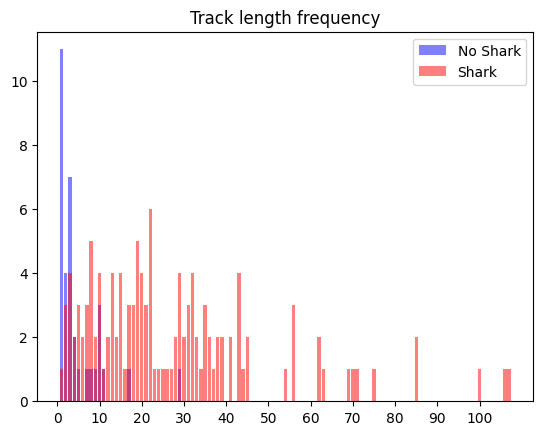

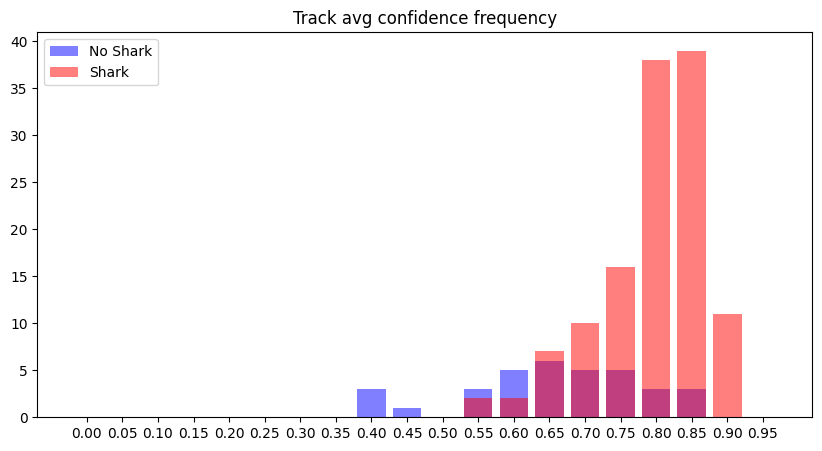

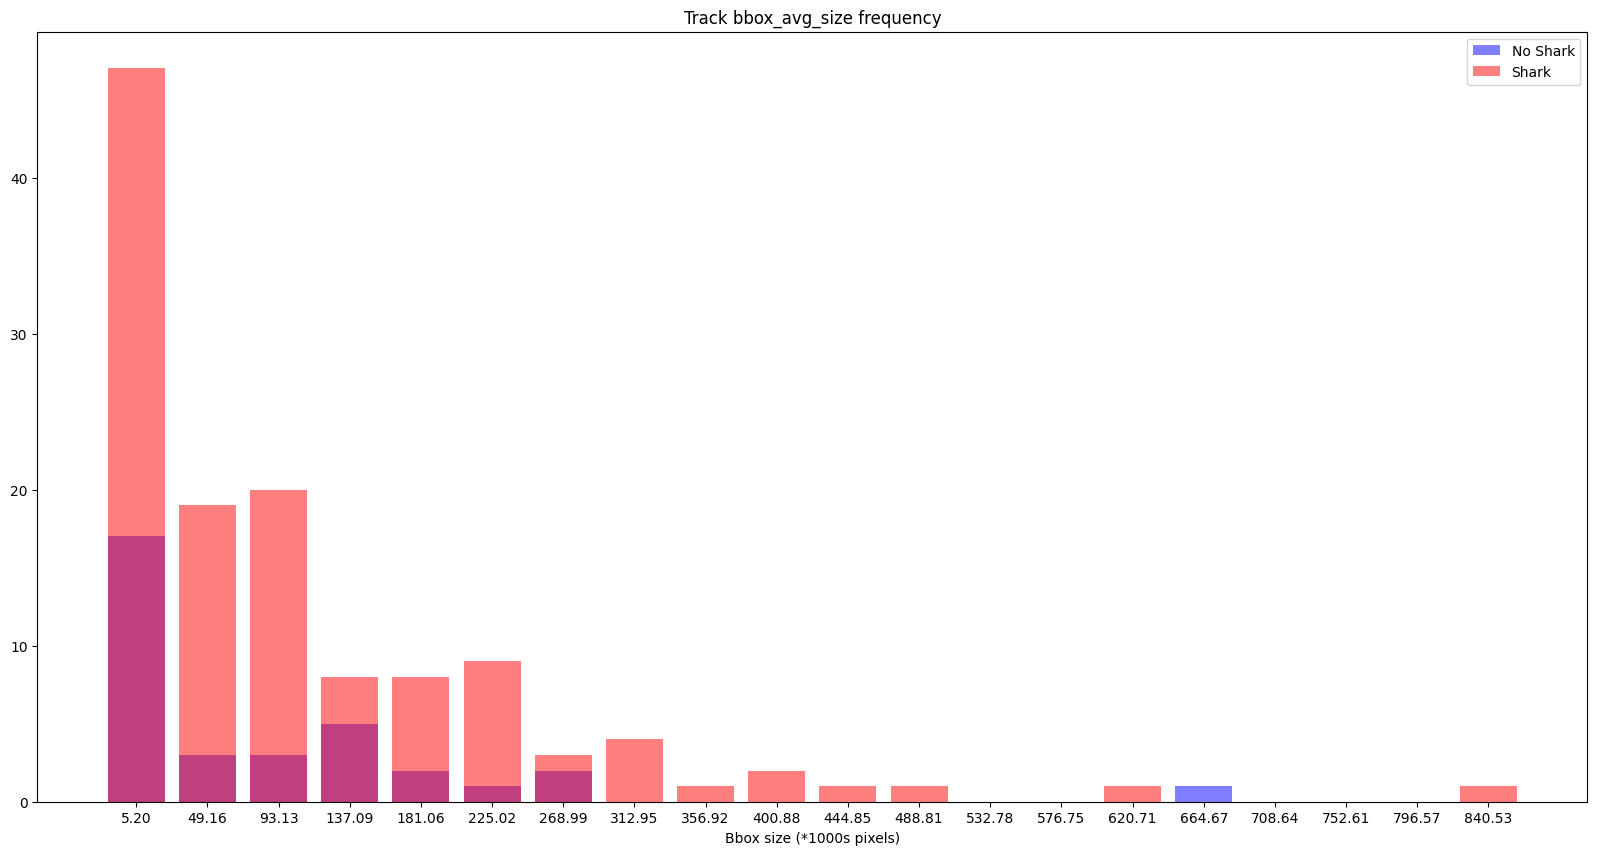

In [99]:
# length
tracks_no_shark_frequency = Counter(length_tracks_no_shark.values())
tracks_shark_frequency = Counter(length_tracks_shark.values())

plot_length_frequency(tracks_shark_frequency, tracks_no_shark_frequency)

# conf
conf_tracks_no_shark_freq, conf_tracks_shark_freq = bucketise_values(conf_tracks_shark, conf_tracks_no_shark, 0, 1)
plot_max_conf_frequency(conf_tracks_shark_freq, conf_tracks_no_shark_freq)


# size
max_bbox_size = max(max(bbox_avg_size_tracks_no_shark.values()), max(bbox_avg_size_tracks_shark.values()))
min_bbox_size = min(min(bbox_avg_size_tracks_no_shark.values()), min(bbox_avg_size_tracks_shark.values()))

bbox_avg_size_tracks_no_shark_freq, bbox_avg_size_tracks_shark_freq = bucketise_values(bbox_avg_size_tracks_shark, bbox_avg_size_tracks_no_shark, min_bbox_size, max_bbox_size)

plot_bbox_freq(bbox_avg_size_tracks_shark_freq, bbox_avg_size_tracks_no_shark_freq)


In [57]:
# get key of min value of length_tracks_shark
min_key = min(bbox_short_tracks_shark, key=bbox_short_tracks_shark.get)
min_key, bbox_short_tracks_shark[min_key]

('gfp/gfp_niue1_track72', 6.1)

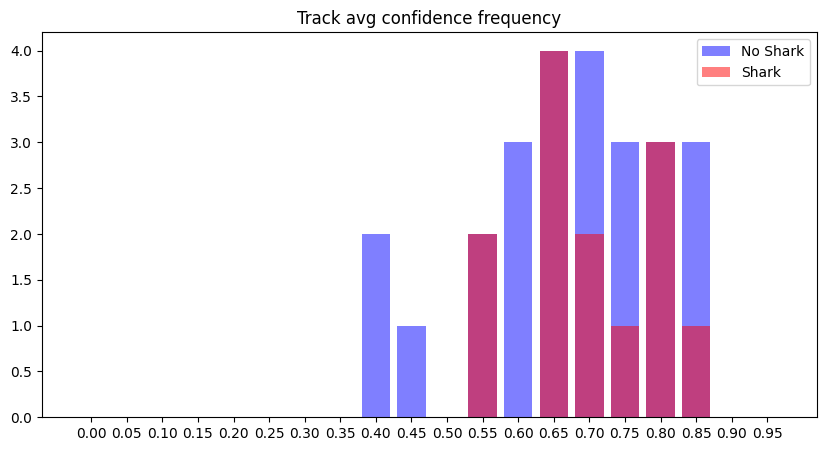

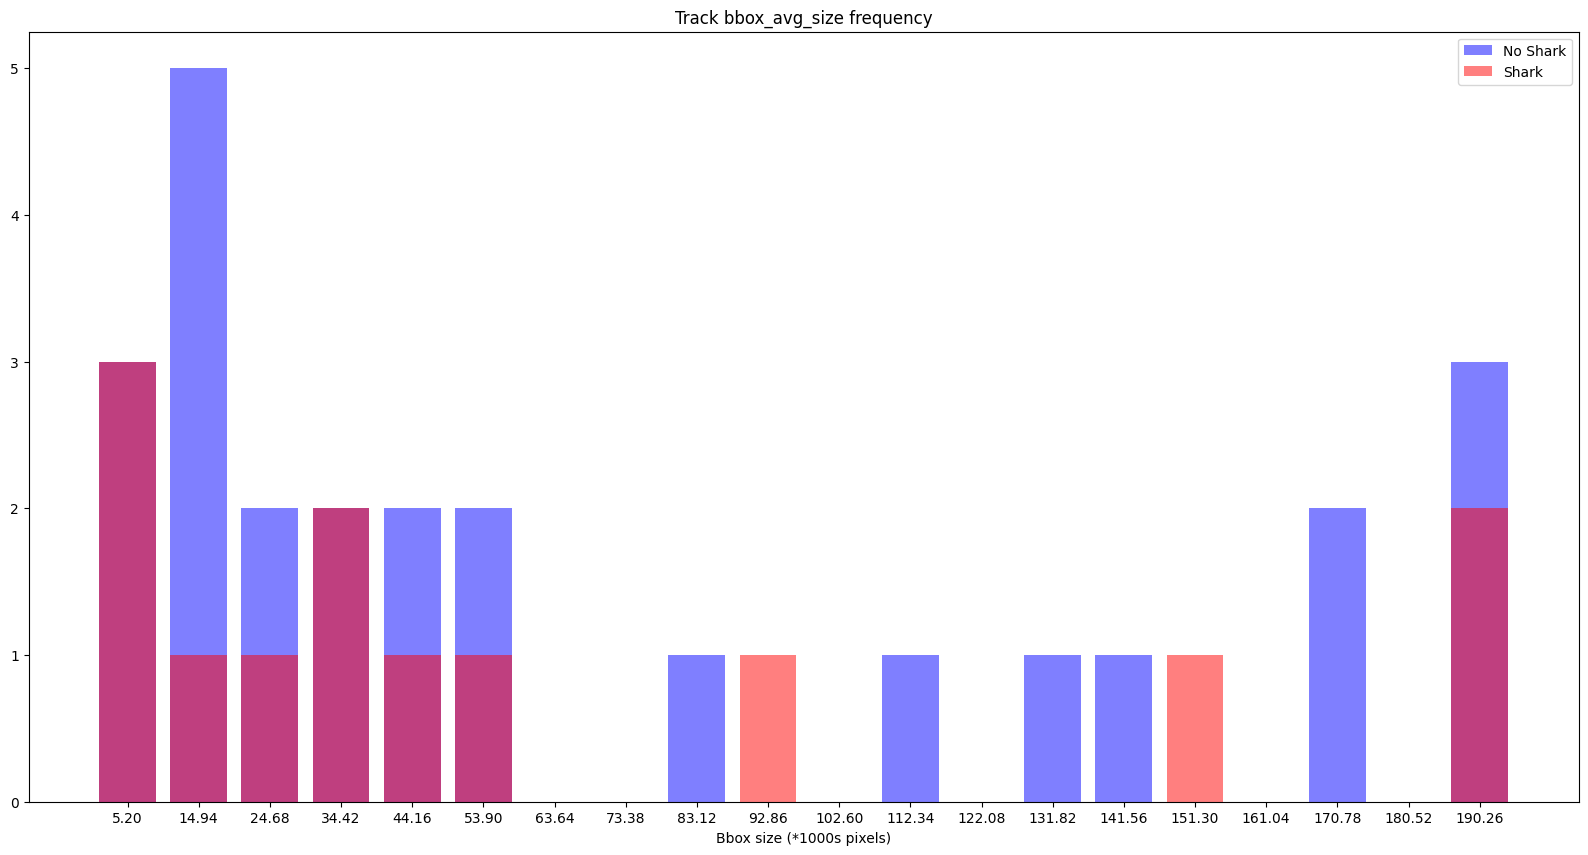

In [100]:
length_thresh = 5

conf_short_tracks_shark = {k: v for k, v in conf_tracks_shark.items() if length_tracks_shark[k] <= length_thresh}
conf_short_tracks_no_shark = {k: v for k, v in conf_tracks_no_shark.items() if length_tracks_no_shark[k] <= length_thresh}

conf_short_tracks_no_shark_freq, conf_short_tracks_shark_freq = bucketise_values(conf_short_tracks_shark, conf_short_tracks_no_shark, 0, 1)
plot_max_conf_frequency(conf_short_tracks_shark_freq, conf_short_tracks_no_shark_freq)

bbox_short_tracks_no_shark = {k: v for k, v in bbox_avg_size_tracks_no_shark.items() if length_tracks_no_shark[k] <= length_thresh}
bbox_short_tracks_shark = {k: v for k, v in bbox_avg_size_tracks_shark.items() if length_tracks_shark[k] <= length_thresh}

max_bbox_size = 200 # max(max(bbox_short_tracks_no_shark.values()), max(bbox_short_tracks_shark.values()))
min_bbox_size = min(min(bbox_short_tracks_no_shark.values()), min(bbox_short_tracks_shark.values()))

bbox_short_tracks_no_shark_freq, bbox_short_tracks_shark_freq = bucketise_values(bbox_short_tracks_shark, bbox_short_tracks_no_shark, min_bbox_size, max_bbox_size)
plot_bbox_freq(bbox_short_tracks_shark_freq, bbox_short_tracks_no_shark_freq)

We expect to have many more shark tracks, as the data is cleaner than out-of-distribution data

Split by confidence of tracks with life lower than 3

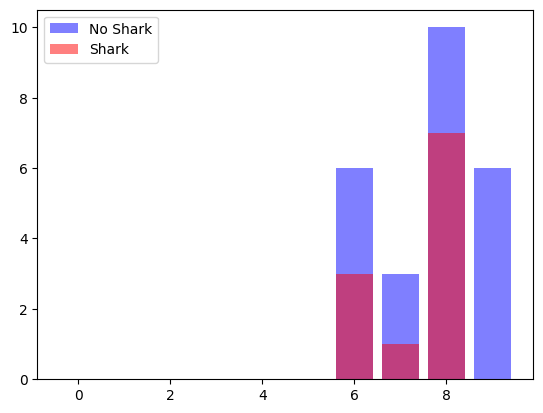

In [43]:
short_tracks_shark = {k: v for k, v in tracks_shark.items() if v <= 3}
short_tracks_no_shark = {k: v for k, v in tracks_no_shark.items() if v <= 3}

conf_short_tracks_shark = {k: v for k, v in conf_tracks_shark.items() if k in short_tracks_shark}
conf_short_tracks_no_shark = {k: v for k, v in conf_tracks_no_shark.items() if k in short_tracks_no_shark}

conf_short_no_shark_tracks_frequency = {k: 0 for k in range(10)}
conf_short_shark_tracks_frequency = {k: 0 for k in range(10)}

conf_no_shark_tracks_frequency, conf_shark_tracks_frequency = bucketise_conf(conf_short_tracks_shark, conf_short_tracks_no_shark)

plt.bar(conf_no_shark_tracks_frequency.keys(), conf_no_shark_tracks_frequency.values(), color='b', label='No Shark', alpha=0.5)
plt.bar(conf_shark_tracks_frequency.keys(), conf_shark_tracks_frequency.values(), color='r', label='Shark', alpha=0.5)

plt.legend()
plt.show()


### Plot FP

In [ ]:
annotation_base_dir = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/annotations/phase2_cstm_botsort_5fps'

for source in os.listdir(annotation_base_dir):
  for annotation in os.listdir(os.path.join(annotation_base_dir, source)):
    # if 'val1_medium2' not in annotation:
      # continue
    assert annotation.endswith('.csv')
    base_video_path = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/frame_extraction_raw'
    video_path = os.path.join(base_video_path, source, 'videos', annotation.replace('_tracks_5fps.csv', '.mp4'))
    predictions = os.path.join(annotation_base_dir, source, annotation)
    predictions_df = pd.read_csv(predictions, skiprows=lambda x: x in [1])

    fps = 5
    track_ids = set()
    frames = set()
    for index, row in predictions_df.iterrows():
      frame_to_inspect = row['3: Unique Frame Identifier']
      conf = row['8: Detection or Length Confidence']
      track_id = row['# 1: Detection or Track-id']

      # skip every 10 frames
      # if any([frame_to_inspect + n in frames for n in range(-5, 5)]): 
        # continue
      frames.add(frame_to_inspect)
      track_name = f"{source}/{annotation.replace('_tracks_5fps.csv', '')}_track{track_id}"
      ref_tracks = conf_short_tracks_shark
      if track_name in track_ids or track_name not in ref_tracks:
        continue
      track_ids.add(track_name)
      print(f'{frame_to_inspect=}, {conf=}, time: {frame_to_inspect/fps}, {track_id=}, {ref_tracks[track_name]=}, {track_name}, {length_tracks_shark[track_name]=}')
      plt.figure(figsize=(10, 5))
      plot_from_video(video_path, frame_to_inspect, fps, predictions_df)
      plt.pause(1)
      plt.clf()
